In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import time
import matplotlib.pyplot as plt
import utils

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchio as tio

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import LeaveOneOut, train_test_split

from datetime import datetime

# from google.colab import drive

/home/michele/miniconda3/envs/dMRI/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
info_df = pd.read_csv(f"../study/stats/info.csv")

In [19]:
info_df = pd.read_csv(f"../study/stats/info.csv")

info_df.iloc[:19,:]

,ID,resp,respPart,age,therapy_duration,sex,AEDs,benzo,epilepsy_onset_age,epilepsy_type,epilepsy_duration
0,VNSLC_01,1.0,2.0,36.0,93.0,0.0,3.0,0.0,5.0,0.0,31.0
1,VNSLC_02,1.0,2.0,29.0,13.0,1.0,2.0,0.0,14.0,0.0,15.0
2,VNSLC_03,1.0,2.0,65.0,234.0,0.0,3.0,0.0,15.0,0.0,50.0
3,VNSLC_04,1.0,2.0,34.0,11.0,1.0,2.0,0.0,8.0,1.0,26.0
4,VNSLC_06,0.0,0.0,62.0,136.0,1.0,2.0,0.0,36.0,1.0,26.0
5,VNSLC_07,1.0,2.0,46.0,216.0,1.0,2.0,0.0,5.0,1.0,41.0
6,VNSLC_09,1.0,2.0,47.0,13.0,1.0,3.0,0.0,2.0,1.0,45.0
7,VNSLC_10,1.0,1.0,21.0,30.0,0.0,4.0,1.0,6.0,1.0,15.0
8,VNSLC_11,1.0,2.0,46.0,6.0,1.0,3.0,0.0,0.0,1.0,46.0
9,VNSLC_12,1.0,1.0,31.0,134.0,0.0,3.0,0.0,18.0,1.0,13.0


In [20]:
study_path = "../study"

info_df = pd.read_csv(f"{study_path}/stats/info.csv")

subjects = []

for idx, row in info_df.iterrows():
    if "VNSLC" not in row.ID:
        continue
    
    subj_dict = {
        "id": row.ID,
        "age": row.age,
        "sex": row.sex,
        "epilepsy_type": row.epilepsy_type,
        "epilepsy_onset_age": row.epilepsy_onset_age,
        "therapy_duration": row.therapy_duration,
        "AEDs": row.AEDs,
        "FA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_FA.nii.gz"),
        "MD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_MD.nii.gz"),
        "AD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_AD.nii.gz"),
        "RD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_RD.nii.gz"),
        "wFA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wFA.nii.gz"),
        "wMD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wMD.nii.gz"),
        "wAD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wAD.nii.gz"),
        "wRD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wRD.nii.gz"),
        "diamond_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_frac_csf.nii.gz"),
        "icvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_icvf.nii.gz"),
        "odi": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_odi.nii.gz"),
        "fextra": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fextra.nii.gz"),
        "fiso": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fiso.nii.gz"),
        "wfvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_wfvf.nii.gz"),
        "mf_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_frac_csf.nii.gz"),

    }

    subjects.append(tio.Subject(subj_dict))

In [23]:
subjects_dataset = tio.SubjectsDataset(subjects)

In [27]:
subjects_dataset[0]

Subject(Keys: ('id', 'age', 'sex', 'epilepsy_type', 'epilepsy_onset_age', 'therapy_duration', 'AEDs', 'FA', 'MD', 'AD', 'RD'); images: 4)

In [2]:
dataset_dMRI, affine = utils.getVolumeDS("../study/")

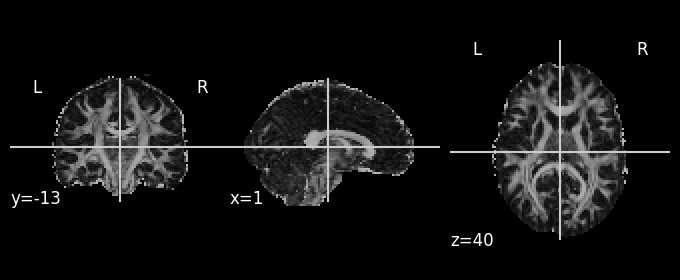

In [3]:
nlplt.plot_anat(nib.Nifti1Image(dataset_dMRI[1,0,:,:,:], affine[1]))

In [6]:
randRot = transforms.RandomRotation(180)

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

In [3]:
# drive.mount('/content/drive')
# 
# study_fold = '/content/drive/MyDrive/Thesis:Epilepsy/study/'
# dataset_path = os.path.join(study_fold, "stats/datasetRadiomicsReduced.csv")

dataset_path = "../study/stats/datasetRadiomicsReduced.csv"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv(dataset_path, index_col="ID")

In [6]:
class DatasetDiffusionMRI(Dataset):
  def __init__(self, X, y, device):
    self.X = X
    self.y = y
    self.device = device

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    features = self.X.iloc[idx, :].to_numpy()
    label = self.y.iloc[idx].to_numpy(dtype="float64")

    return torch.from_numpy(features).to(self.device), torch.from_numpy(label).to(self.device)

In [263]:
def looPytorch():
  avg_score = []

  for train_val_idx, test_idx in LeaveOneOut().split(df):
    train_val = df.iloc[train_val_idx, :]
    test = df.iloc[test_idx, :]
    for train_idx, val_idx in LeaveOneOut().split(train_val):
      train = train_val.iloc[train_idx, :]
      val = train_val.iloc[val_idx, :]

      # train the model

      # evaluate the model, fo the hyperParameters selection

    # Select the best model and use it for the test
    # test the model, compute the score and add tot the list

  # mean of avg_score
  return np.mean(avg_score)


In [7]:
X, y, y3 = df.iloc[:, 2:], df.iloc[:,:1], df.iloc[:, 1:2]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.12, shuffle=True, stratify=y3)
y3_train_val = y3.loc[y_train_val.index]
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.14, shuffle=True, stratify=y3_train_val)

del df
del X
del y
del y3
del X_train_val
del y_train_val
del y3_train_val

In [9]:
class ModelTrainer():
    def __init__(self, train_dataset, val_dataset, model, device, loss_fn, optimizer, batch_size):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.model = model.to(device)
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size,
            shuffle=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size,
            shuffle=True
        )

        self.epoch_number = 0

    def __trainOneEpoch(self, epoch_index, tb_writer):
        running_loss = 0

        for i, data in enumerate(self.train_loader):

            # Step 1: Get the features and the label
            features, labels = data

            # Step 2: Zero the gradient
            self.optimizer.zero_grad()

            # Step 3: Make predictions
            outputs = self.model(features)

            # Step 4: Compute the loss
            loss = self.loss_fn(outputs, labels)

            # - : Compute the gradient
            loss.backward()

            # Step 5: Adjust weights
            self.optimizer.step()

            # Data and report Statistics
            curr_loss = loss.item()
            running_loss += curr_loss

            # since the small dataset, report the loss at each batch
            print("\tbatch {} loss: {}".format(i+1, curr_loss))
            tb_x = epoch_index*len(self.train_loader) + i + 1
            tb_writer.add_scalar("Loss/Train", curr_loss, tb_x)

        return running_loss/(i+1)


    def train(self, epochs):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

        EPOCHS = epochs

        best_vloss = 1_000_000

        for epoch in range(EPOCHS):
            print("EPOCH {}".format(self.epoch_number + 1))

            # Set the model to training mode
            self.model.train()
            avg_loss = self.__trainOneEpoch(self.epoch_number, writer)

            # Set the model to validation mode
            running_vloss = 0.0
            self.model.eval()

            with torch.no_grad():
                for i, vdata in enumerate(self.val_loader):
                    # Get the features and the labels
                    features, labels = vdata
                    features = features.to(self.device)
                    labels = labels.to(self.device)

                    voutputs = self.model(features)

                    loss = self.loss_fn(voutputs, labels)
                    running_vloss +=loss

            avg_vloss = running_vloss/(i+1)
            print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

            # Data and report Statistics
            writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    self.epoch_number + 1)
            writer.flush()

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = "model_{}_{}".format(timestamp, self.epoch_number)
                torch.save(self.model.state_dict(), model_path)

            self.epoch_number += 1


Creating my neural network

In [10]:
class NeuralNetwork(nn.Module):
  def __init__(self, in_features: int, hidden_features: int):
    super().__init__()

    self.activation = nn.ReLU()

    self.fc1 = nn.Linear(
        in_features=in_features,
        out_features=hidden_features,
        dtype=torch.float64
    )
    self.fc2 = nn.Linear(
        in_features=hidden_features,
        out_features=1,
        dtype=torch.float64
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    X = self.activation(self.fc1(X))
    X = self.fc2(X)
    X = self.sigmoid(X)
    return X

In [11]:
network = NeuralNetwork(X_train.shape[1], 100).to(device)

model_trainer = ModelTrainer(
    DatasetDiffusionMRI(X_train, y_train, device),
    DatasetDiffusionMRI(X_val, y_val, device),
    network,
    device,
    nn.BCELoss(),
    optim.Adam(network.parameters(), lr=1),
    batch_size=4,
)

In [13]:
model_trainer.train(100)

EPOCH 11
	batch 1 loss: 25.0
	batch 2 loss: 25.0
	batch 3 loss: 50.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 12
	batch 1 loss: 25.0
	batch 2 loss: 50.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 13
	batch 1 loss: 0.0
	batch 2 loss: 50.0
	batch 3 loss: 50.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 14
	batch 1 loss: 25.0
	batch 2 loss: 50.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 15
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 16
	batch 1 loss: 25.0
	batch 2 loss: 75.0
	batch 3 loss: 1.436309697269979e-35
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 17
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 18
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666


KeyboardInterrupt: 

In [ ]:
X_train.shape

In [ ]:
target_loss = 1e-4

def optimize_model():
  optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-3)

  while loss > target_loss:
    optimizer.zero_grad()
    outpur = model()